# Imports

In [219]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [4]:
from explainerdashboard.explainers import *
from explainerdashboard.datasets import *

# ClassifierExplainer:

In [167]:
X_train, y_train, X_test, y_test = titanic_survive()
train_names, test_names = titanic_names()

feature_descriptions = {
    "Sex": "Gender of passenger",
    "Deck": "The deck the passenger had their cabin on",
    "PassengerClass": "The class of the ticket: 1st, 2nd or 3rd class",
    "Fare": "The amount of money people paid", 
    "No_of_relatives_on_board": "number of siblings, spouses, parents plus children on board",
    "Embarked": "the port where the passenger boarded the Titanic. Either Southampton, Cherbourg or Queenstown",
    "Age": "Age of the passenger",
    "No_of_siblings_plus_spouses_on_board": "The sum of the number of siblings plus the number of spouses on board",
    "No_of_parents_plus_children_on_board" : "The sum of the number of parents plus the number of children on board",
}

In [174]:
model = RandomForestClassifier(n_estimators=50, max_depth=5)
model.fit(X_train, y_train)

explainer = ClassifierExplainer(model, X_test, y_test, 
                                cats=['Sex', 'Deck', 'Embarked'],
                                idxs=test_names, #names of passengers 
                                descriptions=feature_descriptions,
                                labels=['Not survived', 'Survived'])


RandomForestClassifier(max_depth=5, n_estimators=50)

Note: shap=='guess' so guessing for RandomForestClassifier shap='tree'...
Note: model_output=='probability', so assuming that raw shap output of RandomForestClassifier is in probability space...
Generating self.shap_explainer = shap.TreeExplainer(model)
Note: You can always monkeypatch self.shap_explainer if desired...


## Importances

In [181]:
explainer.mean_abs_shap_df(cats=True, cutoff=0.01)

Feature  MEAN_ABS_SHAP
0                       Sex       0.175847
1                      Deck       0.056893
2            PassengerClass       0.040986
3                      Fare       0.040081
4                  Embarked       0.017216
5  No_of_relatives_on_board       0.015215
6                       Age       0.012919

In [183]:
explainer.permutation_importances_df(cats=False, topx=12)

Feature  Importance
0                                   Fare   -0.003020
2                                    Age   -0.020925
3                         PassengerClass    0.008198
4   No_of_siblings_plus_spouses_on_board   -0.018013
5   No_of_parents_plus_children_on_board   -0.012620
6                             Sex_female    0.082192
7                               Sex_male    0.031172
8                                Sex_nan    0.000000
9                                 Deck_A    0.000755
10                                Deck_B    0.000431
11                                Deck_C    0.000863
12                                Deck_D    0.000378

### Mean absolute shap importances, grouping onehotencoded:

In [175]:
explainer.plot_importances(kind='shap', topx=5, cats=True, round=3)

Calculating shap values...


### Permutation importances, not grouping categorical vars, showing top 10

In [24]:
explainer.plot_importances(kind='permutation', topx=10, cats=False, round=3)

Calculating importances...


## detailed shap summary

In [38]:
explainer.plot_shap_summary(topx=10, cats=True)

In [39]:
explainer.plot_shap_summary(topx=None, cats=False)

## interaction importances

### mean absolute shap interaction values for interactions with 'Sex' 
- the direct effect is usually the largest
- in this case PassengerClass shows the biggest interaction with gender

In [25]:
explainer.plot_interactions('Sex', cats=True, topx=5)

Calculating shap interaction values...


In [26]:
explainer.plot_interactions('Fare', cats=False, topx=5)

### Detailed shap interactions summary:

In [41]:
explainer.plot_shap_interaction_summary("Sex", cats=True)

## Contributions

In [177]:
index = 0 # explain prediction for first row of X_test
explainer.contrib_df(index, cats=True, topx=8)

col  contribution      value  cumulative      base
0                base_value      0.389696          -    0.389696  0.000000
1                       Sex      0.247437     female    0.637133  0.389696
2            PassengerClass      0.075344          1    0.712477  0.637133
3                      Deck      0.072961          C    0.785438  0.712477
4                      Fare      0.068320    71.2833    0.853758  0.785438
5                  Embarked      0.036964  Cherbourg    0.890723  0.853758
6                       Age     -0.023555         38    0.867168  0.890723
7  No_of_relatives_on_board      0.010538          1    0.877706  0.867168
8                      REST      0.012250          -    0.889956  0.877706

In [178]:
explainer.plot_shap_contributions(index, cats=True, topx=8, round=2)

In [43]:
name = test_names[0] # explainer prediction for name
print(name)
explainer.plot_shap_contributions(name, cats=False)

Cumings, Mrs. John Bradley (Florence Briggs Thayer)


## Shap dependence plots

In [54]:
explainer.plot_shap_dependence("Age")

### color by sex

In [55]:
explainer.plot_shap_dependence("Age", color_col="Sex", cats=True)

### color by Fare

In [56]:
explainer.plot_shap_dependence("Age", color_col="Fare")

### Highlight particular index

In [57]:

explainer.plot_shap_dependence("Age", color_col="Sex", cats=True, highlight_idx=5)

## Shap interactions plots

In [58]:
explainer.plot_shap_interaction("Sex", "PassengerClass", cats=True)

In [59]:
explainer.plot_shap_interaction("PassengerClass", "Sex", cats=True)

In [62]:
explainer.plot_shap_interaction("Fare", "Age", highlight_idx=5)

In [61]:
explainer.plot_shap_interaction("Age", "Fare")

## partial dependence plots (pdp)

### Plot average general partial dependence plot with ice lines for specific observations

In [77]:
explainer.plot_pdp("Fare")

In [78]:
explainer.plot_pdp("Sex")

### highlight pdp for specific observation

In [79]:
name = test_names[5]
print(name)
explainer.plot_pdp("Fare", name)

Saundercock, Mr. William Henry


### with default parameters:

In [82]:
explainer.plot_pdp("Age", index=5, drop_na=True, sample=100,
                    num_grid_lines=100, num_grid_points=10)

### adjusting parameters:

- `drop_na=False` no longer drop values equal to self.na_fill (-999 by default)
- `sample=200` sample 200 samples for calculating the average
- `num_grid_lines=10`  display 10 additional grid lines
- `num_grid_points=50` take 50 points along the x axis to calculate the lines

In [83]:
explainer.plot_pdp("Age", index=5, drop_na=False, sample=200,
                    num_grid_lines=10, num_grid_points=50)

## Classification validation plots:

In [161]:
explainer.metrics(cutoff=0.8)

{'accuracy': 0.745,
 'precision': 1.0,
 'recall': 0.3013698630136986,
 'f1': 0.4631578947368421,
 'roc_auc_score': 0.8705641246898933,
 'pr_auc_score': 0.8551406992130804,
 'log_loss': 0.41599569341419307}

In [159]:
from IPython.display import display, Markdown
display(Markdown(explainer.prediction_result_markdown(test_names[3])))

Calculating prediction probabilities...
Calculating pred_percentiles...


# Prediction for Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg):
##### Not survived: 44.82 
##### Survived: 55.18 
##### Actual Outcome: Survived

##### In top 24.0% percentile probability Survived

### confusion matrix

In [91]:
explainer.plot_confusion_matrix(cutoff=0.5, normalized=False, binary=True)

#### For multiclass classifiers, `binary=False` would display e.g. a 3x3 confusion matrix
- in this case it's a binary classifier, so binary=False makes no difference

In [92]:
explainer.plot_confusion_matrix(cutoff=0.5, normalized=True, binary=False)

### precision plot
- if the classifier works well the predicted probability should be the same as the observed probability per bin, so we would expect a nice straight line from 0 to 1

#### based on bin size:

In [84]:
explainer.plot_precision(bin_size=0.1)

#### based on quantiles, showing all classes, adding in a cutoff value

In [86]:
explainer.plot_precision(quantiles=10, cutoff=0.75, multiclass=True)

### Cumulative precision

In [87]:
explainer.plot_cumulative_precision()

### lift curve

In [93]:
explainer.plot_lift_curve(cutoff=None, percentage=False, round=2)

In [94]:
explainer.plot_lift_curve(cutoff=0.75, percentage=True, round=2)

### Plot classification:

In [97]:
explainer.plot_classification()

In [98]:
explainer.plot_classification(cutoff=0.75, percentage=False)

### ROC AUC Curve

In [99]:
explainer.plot_roc_auc(cutoff=0.75)

### Plot PR AUC

In [101]:
explainer.plot_pr_auc(cutoff=0.25)

# RegressionExplainer

In [110]:
X_train, y_train, X_test, y_test = titanic_fare()
train_names, test_names = titanic_names()

feature_descriptions = {
    "Sex": "Gender of passenger",
    "Deck": "The deck the passenger had their cabin on",
    "PassengerClass": "The class of the ticket: 1st, 2nd or 3rd class",
    "Fare": "The amount of money people paid", 
    "No_of_relatives_on_board": "number of siblings, spouses, parents plus children on board",
    "Embarked": "the port where the passenger boarded the Titanic. Either Southampton, Cherbourg or Queenstown",
    "Age": "Age of the passenger",
    "No_of_siblings_plus_spouses_on_board": "The sum of the number of siblings plus the number of spouses on board",
    "No_of_parents_plus_children_on_board" : "The sum of the number of parents plus the number of children on board",
}

In [111]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=50, max_depth=5)
model.fit(X_train, y_train)

explainer = RegressionExplainer(model, X_test, y_test, 
                                cats=['Sex', 'Deck', 'Embarked'], 
                                idxs=test_names, 
                                units="$")

RandomForestRegressor(max_depth=5, n_estimators=50)

Note: shap=='guess' so guessing for RandomForestRegressor shap='tree'...
Generating self.shap_explainer = shap.TreeExplainer(model)
You can monkeypatch self.shap_explainer if desired...


## Importances

### Mean absolute shap importances, grouping onehotencoded:

In [112]:
explainer.plot_importances(kind='shap', topx=5, cats=True, round=3)

Calculating shap values...


### Permutation importances, not grouping categorical vars, showing top 10

In [113]:
explainer.plot_importances(kind='permutation', topx=10, cats=False, round=3)

Calculating importances...


## detailed shap summary

In [114]:
explainer.plot_shap_summary(topx=10, cats=True)

Calculating shap values...


In [115]:
explainer.plot_shap_summary(topx=None, cats=False)

## interaction importances

### mean absolute shap interaction values for interactions with 'Sex' 
- the direct effect is usually the largest
- in this case PassengerClass shows the biggest interaction with gender

In [116]:
explainer.plot_interactions('Sex', cats=True, topx=5)

Calculating shap interaction values...
Calculating shap interaction values...


In [118]:
explainer.plot_interactions('Age', cats=False, topx=5)

### Detailed shap interactions summary:

In [119]:
explainer.plot_shap_interaction_summary("Sex", cats=True)

## Contributions

In [120]:
index = 0 # explain prediction for first row of X_test
explainer.plot_shap_contributions(index, cats=True, topx=8, round=2)

In [121]:
name = test_names[0] # explainer prediction for name
print(name)
explainer.plot_shap_contributions(name, cats=False)

Cumings, Mrs. John Bradley (Florence Briggs Thayer)


## Shap dependence plots

In [122]:
explainer.plot_shap_dependence("Age")

### color by sex

In [123]:
explainer.plot_shap_dependence("Age", color_col="Sex", cats=True)

### color by PassengerClass

In [124]:
explainer.plot_shap_dependence("Age", color_col="PassengerClass")

### Highlight particular index

In [125]:

explainer.plot_shap_dependence("Age", color_col="Sex", cats=True, highlight_idx=5)

## Shap interactions plots

In [126]:
explainer.plot_shap_interaction("Sex", "PassengerClass", cats=True)

In [127]:
explainer.plot_shap_interaction("PassengerClass", "Sex", cats=True)

In [131]:
explainer.plot_shap_interaction("PassengerClass", "Age", highlight_idx=5)

In [132]:
explainer.plot_shap_interaction("Age", "PassengerClass")

## partial dependence plots (pdp)

### Plot average general partial dependence plot with ice lines for specific observations

In [133]:
explainer.plot_pdp("PassengerClass")

In [135]:
explainer.plot_pdp("Deck")

### highlight pdp for specific observation

In [139]:
name = test_names[17]
print(name)
explainer.plot_pdp("PassengerClass", name)

Hood, Mr. Ambrose Jr


### with default parameters:

In [140]:
explainer.plot_pdp("PassengerClass", index=17, drop_na=True, sample=100,
                    num_grid_lines=100, num_grid_points=10)

### adjusting parameters:

- `drop_na=False` no longer drop values equal to self.na_fill (-999 by default)
- `sample=200` sample 200 samples for calculating the average
- `num_grid_lines=10`  display 10 additional grid lines
- `num_grid_points=50` take 50 points along the x axis to calculate the lines

In [141]:
explainer.plot_pdp("PassengerClass", index=17, drop_na=False, sample=200,
                    num_grid_lines=10, num_grid_points=50)

## Regression validation plots:

In [152]:
explainer.metrics()

{'rmse': 26.8665866967343, 'mae': 12.042762621116744, 'R2': 0.5059717106050351}

In [155]:
from IPython.display import display, Markdown
display(Markdown(explainer.prediction_result_markdown(test_names[3])))

# Prediction for Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg):
##### Prediction: 18.04
##### Actual Outcome: 11.13

### predicted vs actual

In [144]:
explainer.plot_predicted_vs_actual()

In [145]:
explainer.plot_predicted_vs_actual(logs=True)

## plot residuals

In [146]:
explainer.plot_residuals()

In [148]:
explainer.plot_residuals(vs_actual=True)

In [149]:
explainer.plot_residuals(ratio=True)

## residuals vs specific feature

In [150]:
explainer.plot_residuals_vs_feature("Age")

# RandomForestExplainer

`RandomForestClassifierExplainer`. and `RandomForestRegressionExplainer`, provide some additional functionality to visualize the individual trees in the RandomForest.

In [239]:
X_train, y_train, X_test, y_test = titanic_survive()
train_names, test_names = titanic_names()

feature_descriptions = {
    "Sex": "Gender of passenger",
    "Deck": "The deck the passenger had their cabin on",
    "PassengerClass": "The class of the ticket: 1st, 2nd or 3rd class",
    "Fare": "The amount of money people paid", 
    "No_of_relatives_on_board": "number of siblings, spouses, parents plus children on board",
    "Embarked": "the port where the passenger boarded the Titanic. Either Southampton, Cherbourg or Queenstown",
    "Age": "Age of the passenger",
    "No_of_siblings_plus_spouses_on_board": "The sum of the number of siblings plus the number of spouses on board",
    "No_of_parents_plus_children_on_board" : "The sum of the number of parents plus the number of children on board",
}

from sklearn.ensemble import RandomForestRegressor
model = RandomForestClassifier(n_estimators=50, max_depth=5)
model.fit(X_train, y_train)

explainer = RandomForestClassifierExplainer(model, X_test, y_test, 
                                cats=['Sex', 'Deck', 'Embarked'], 
                                idxs=test_names)

RandomForestClassifier(max_depth=5, n_estimators=50)

Note: shap=='guess' so guessing for RandomForestClassifier shap='tree'...
Note: model_output=='probability', so assuming that raw shap output of RandomForestClassifier is in probability space...
Generating self.shap_explainer = shap.TreeExplainer(model)
Note: You can always monkeypatch self.shap_explainer if desired...


In [222]:
name = test_names[20]
print(name)# first row of X_test
explainer.plot_trees(name, highlight_tree=20)

Christmann, Mr. Emil


In [223]:
explainer.decisiontree_df(tree_idx=20, index=name)

node_id   average                feature  value  split direction      left  \
0       0  0.426918         PassengerClass    3.0    2.5     right  0.573290   
1      24  0.309896                    Age   29.0   32.5      left  0.354938   
2      25  0.354938                 Deck_E    0.0    0.5      left  0.342767   
3      26  0.342767  Embarked_Southamption    1.0    0.5     right  0.530973   
4      30  0.239024                 Deck_G    0.0    0.5      left  0.242574   

      right      diff  
0  0.309896 -0.117022  
1  0.066667  0.045042  
2  1.000000 -0.012171  
3  0.239024 -0.103743  
4  0.000000  0.003550

In [224]:
base_value, prediction, decisiontree_df = explainer.decisiontree_df_summary(tree_idx=5, index=name)
print(f"base value: {base_value}, final prediction: {prediction}")
decisiontree_df

base value: 0.37, final prediction: 0.14


value             condition  \
0  Fare=8.05                                     ...  < 10.870850086212158   
1  No_of_siblings_plus_spouses_on_board=0.0      ...          < 3.0          
2  Embarked_Queenstown=0.0                       ...          < 0.5          
3  Fare=8.05                                     ...   >=7.133349895477295   
4  Fare=8.05                                     ...   >=7.183349847793579   

  change prediction  
0  -0.18       0.18  
1  -0.01       0.18  
2  -0.04       0.14  
3  +0.02       0.16  
4  -0.01       0.14

## decision_path
- this graphic is generated by dtreeviz
- See https://explained.ai/decision-tree-viz/index.html for more of the thinking behind this visualization
- dtreeviz generates an SVG gile that gets saved to disk
- but you need a working installation of graphviz for this to work
- Would be nice to turn this into a react component!


20


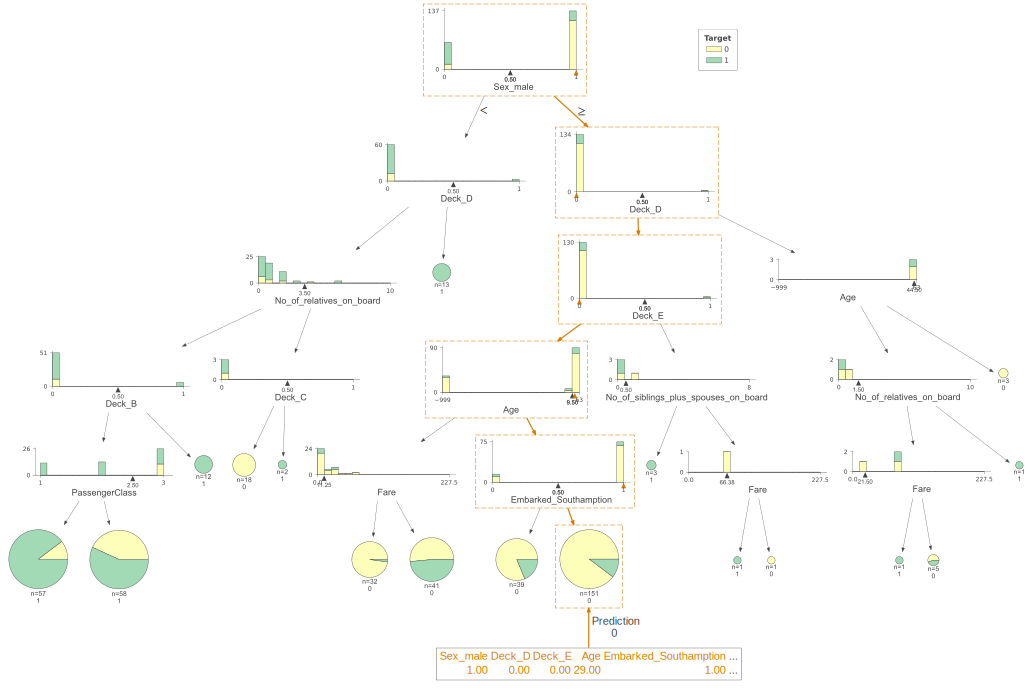

In [242]:
explainer.decision_path(tree_idx=5, index=name)